# Spam Filter - Joe Harpur

Create a spam filter using sample ham and spam emails to train one or more classifiers.

Import data analysis and text processing libraries

In [1]:
import email, string, os, re
from nltk.corpus import stopwords
from dateutil import parser
import pandas as pd
import numpy as np

Import data visualisation libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import machine learning libraries and initialise extra classes

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DataFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values
    
# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

# Read and Convert Data


Read in all emails from ham and spam folders and convert to a pandas dataframe

In [6]:
def read_files(directory):
    #open each text file and extract the body and sent time from the raw email data
    emails=[]
    for filename in os.listdir(directory):
        #open file using os library
        try:
            with open(directory+'/'+filename, encoding='utf8') as fileHandle:
                emailtext = email.message_from_file(fileHandle)
                #read file using email library
        except IOError:
            continue
        if emailtext.is_multipart():
            #if email contains both html and plain text
            for payload in emailtext.get_payload():
                if type(payload.get_payload()) != list:
                    try:
                        content = payload.get_payload().replace('\n', '')
                        hour = parser.parse(emailtext['Received'].split(';')[1]).hour
                        emails.append([content, hour])
                        #extract body of email and remove newline characters
                        #extract hour that email was first received
                        #append to list
                    except:
                        continue
        else:
            try:
                content = emailtext.get_payload().replace('\n', '')
                hour = parser.parse(emailtext['Received'].split(';')[1]).hour
                emails.append([content, hour])
                #extract body of email and remove newline characters
                #extract hour that email was first received
                #append to list
            except:
                continue
    return emails

In [7]:
ham = read_files('ham')

In [8]:
len(ham)

1771

In [7]:
ham[0]

['gaim official apt-rpm repositorys :)#gaimrpm http://gaim.sourceforge.net/apt redhat/7.3/en/i386 releaserpm-src http://gaim.sourceforge.net/apt redhat/7.3/en/i386 releasethought i should post that one too just fell over it :)bye,che_______________________________________________RPM-List mailing list <RPM-List@freshrpms.net>http://lists.freshrpms.net/mailman/listinfo/rpm-list',
 18]

In [9]:
spam = read_files('spam')

In [10]:
len(spam)

1188

In [10]:
spam[0]

['<html><head></head><body><center><font face=3D"times" size=3D"6" color=3D"#000000">Save up to<font color=3D"#ff0000">75%</font> on your Term LifeInsurance!</font><br>  <font face=3D"times" size=3D"4" color=3D"#000000"><i>Compare rates from top insurance companies aroundthe country</i></font><br><br><font face=3D"arial" size=3D"4" color=3D"#7084D6"><b>In our life and times, it\'s important to plan foryour family\'s future, while <br>being comfortable financially.  Choose the rightLife Insurance policy today.</font><p><font face=3D"arial" size=3D"3" color=3D"#000000"><i>Click the link below to compare the lowest ratesand save up to <fontcolor=3D"#ff0000">75%</font></i></b></font>  <p><ahref=3D"http://www.marketing-leader.com/user0202/termquotes/473400/index.h=tm"><fontface=3D"arial"size=3D"4"><b>COMPARE YOUR COVERAGE</b></font></a><p><font face=3D"times" size=3D"5" color=3D"#000000">You\'ll be able to compare rates and get a freeapplication in <i>less than a minute!</i></font><p><font 

Convert both lists to panda dataframes and then concatonate into one

In [11]:
def to_dataframe(lst, name):
    #convert to df with columns message, hour sent, type, and length
    df = pd.DataFrame(lst, columns=['message', 'hour sent'])
    df['type'] = name
    df['length'] = df['message'].apply(len)
    return df

In [12]:
ham_df = to_dataframe(ham, 'ham')
spam_df = to_dataframe(spam, 'spam')
df = pd.concat([ham_df, spam_df], ignore_index=True)

Check the first five rows to ensure that the dataframe looks correct

In [13]:
df.head()

,message,hour sent,type,length
0,gaim official apt-rpm repositorys :)#gaimrpm h...,18,ham,376
1,">>>>> ""E"" == Elias Sinderson <elias@cse.ucsc.e...",5,ham,2359
2,Thanks that helps. There's still so little in...,10,ham,6167
3,So sprach Malte S. Stretz am 2002-07-21 um 01:...,13,ham,1338
4,"You could try HTTrack, available here: http://...",7,ham,303


# Exploratory Analysis and Visualisation

Initial analysis and visualisation of data to determine what cleaning needs to be done and to determine
the best approaches towards the solution. 

Exploring the amount of ham emails sent per hour versus the amount of spam emails sent per hour.
Ham emails seem to be highest over a ten hour period between 5am and 2pm. This seems odd but may be explained by 
different time zones and may actually reflect a working day between either 8am and 5pm or between 9am and 6pm.
The big spikes may indicate the start of the working day and the time directly after lunch. Spam emails do also show
a minor spike during these hours but are also quite uniform over the other hours.

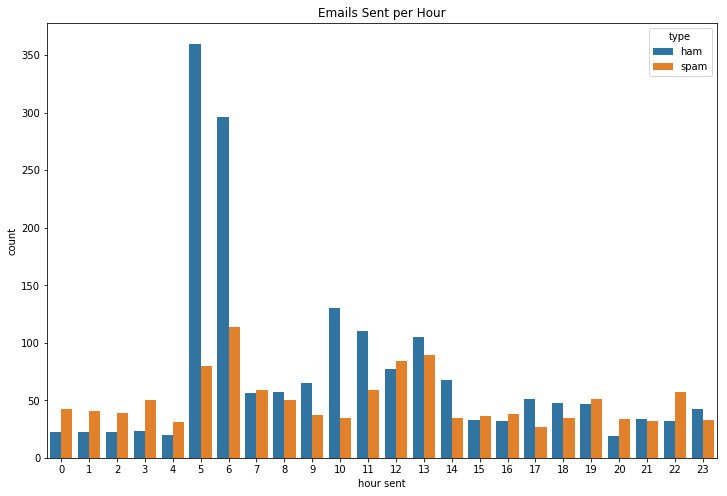

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Emails Sent per Hour')
sns.countplot('hour sent',data=df, hue='type')

The following visualisations show the relationship between the amount of each type of email and their length. The vast majority
of emails are grouped around the lower end of the scale but we can see that the scale extends up past the 300,000 character mark
indicating that there are a few enormous emails in there.

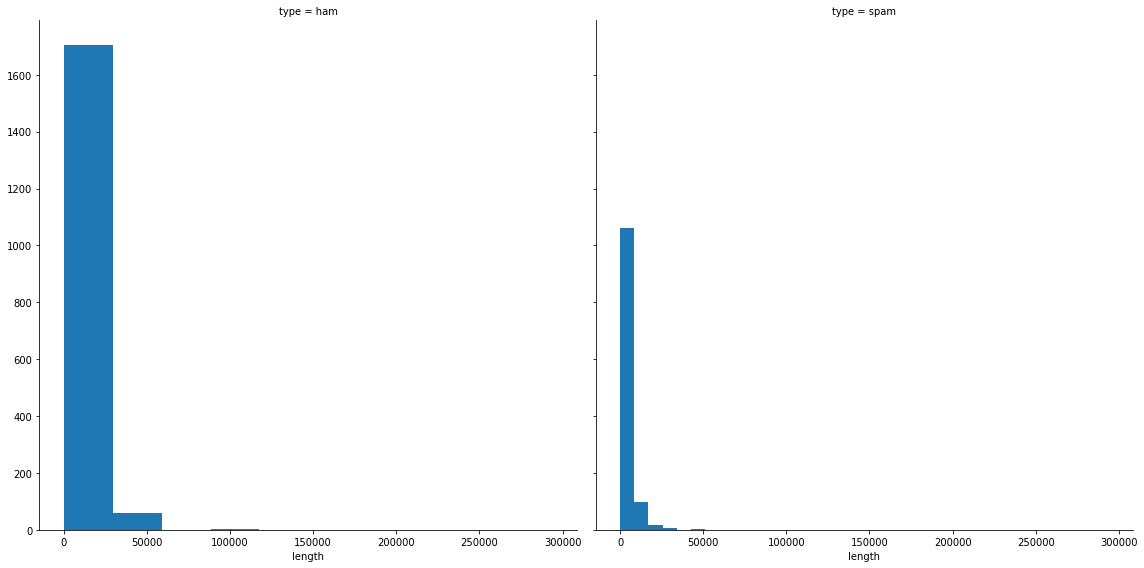

In [15]:
g = sns.FacetGrid(df,col='type', size=8)
g.map(plt.hist, 'length')

This pairplot shows these outliers more clearly.

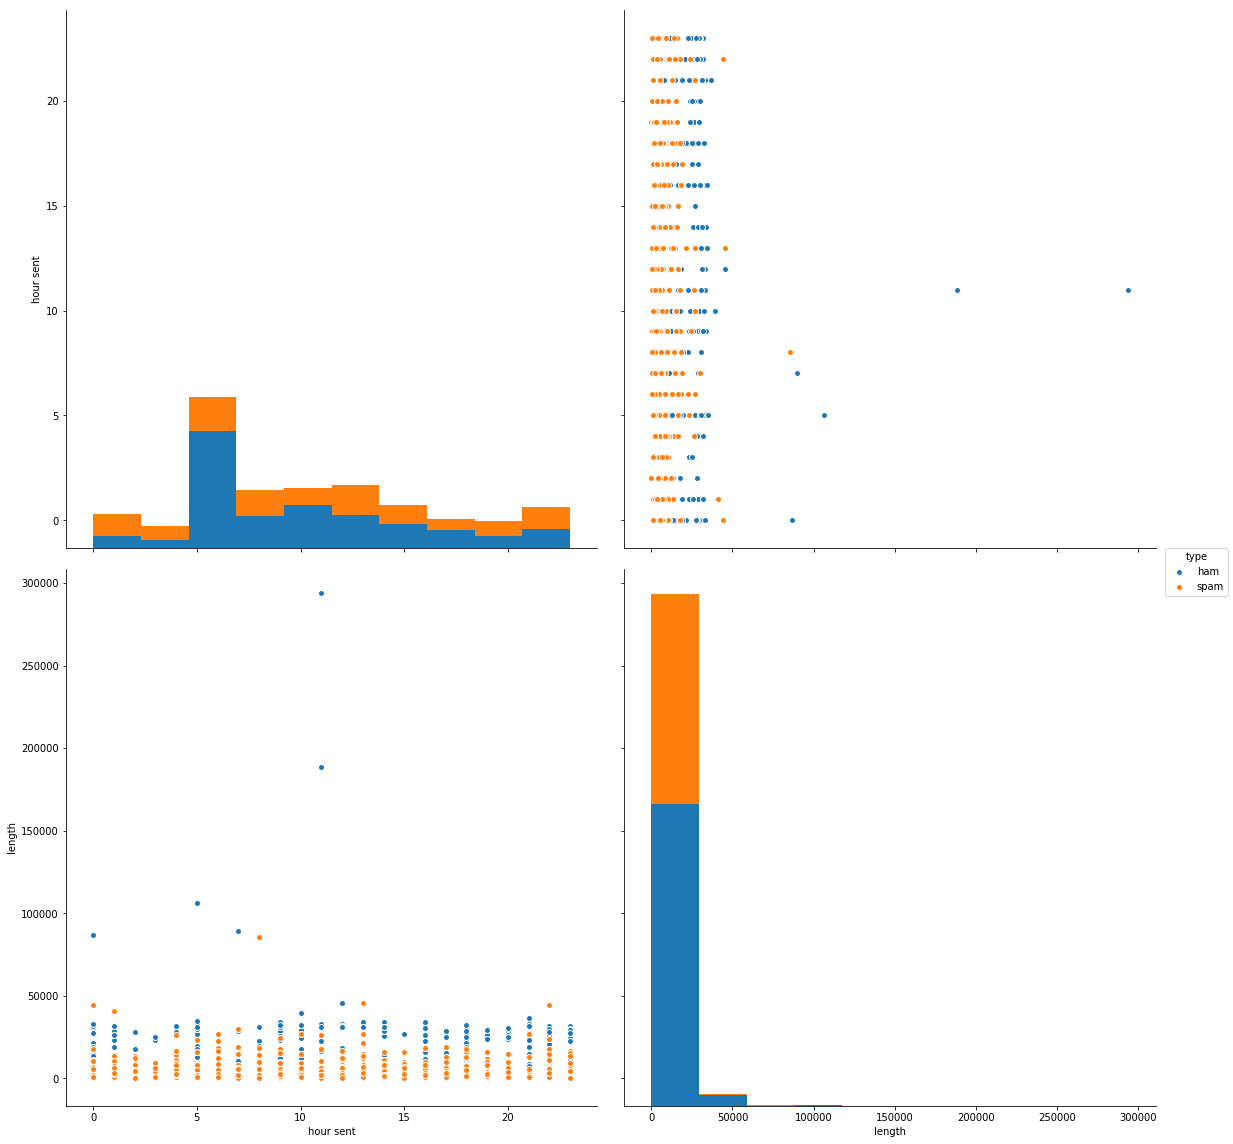

In [16]:
sns.pairplot(df, hue='type', size=8, aspect=1)

# Data Cleaning and Preprocessing

Identify our input and target features, split our data into training and testing data, and create a pipeline. Additional cleaning and vectorization is performed within the pipeline.

We can check what the largest email is.

In [14]:
df['length'].max()

294024

In [15]:
df['length'].argmax()

1502

In [16]:
df.iloc[1502]['message'][:1000]

'Qk1mXQMAAAAAAHYAAAAoAAAA+AIAAEQCAAABAAQAAAAAAPBcAwDEDgAAxA4AAAAAAAAAAAAAAAAAAAAAgAAAgAAAAICAAIAAAACAAIAAgIAAAICAgADAwMAAAAD/AAD/AAAA//8A/wAAAP8A/wD//wAA////AHd3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3+I+Hj4eIiIiIiI+I//iIiIiIj4iP+P/4iP+IiIiIj3h4eP/4iIiIiIiP/3d///+IiIiIiI//////93d/iIiIh3f3d3h3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d3d

This email is obviously of no use. The visualisations indicate that most emails are below a certain character length so 
we can check how many are actually above a certain level.

In [20]:
df[df['length']>10000].groupby('type').size()

type
ham     191
spam     97
dtype: int64

There are not many, and a lot of them are garbage so we can remove outliers above the 10,000 character mark.

In [21]:
df.drop(df[df['length']>10000].index, inplace=True)

The visualisations now show a much nicer spread.

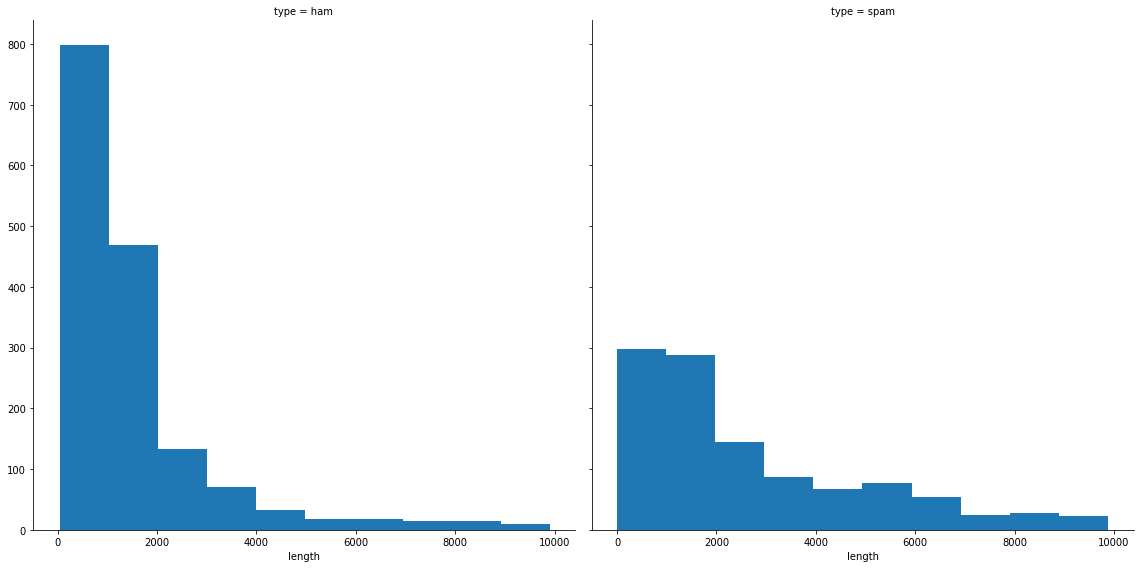

In [22]:
g = sns.FacetGrid(df,col='type', size=8)
g.map(plt.hist, 'length')

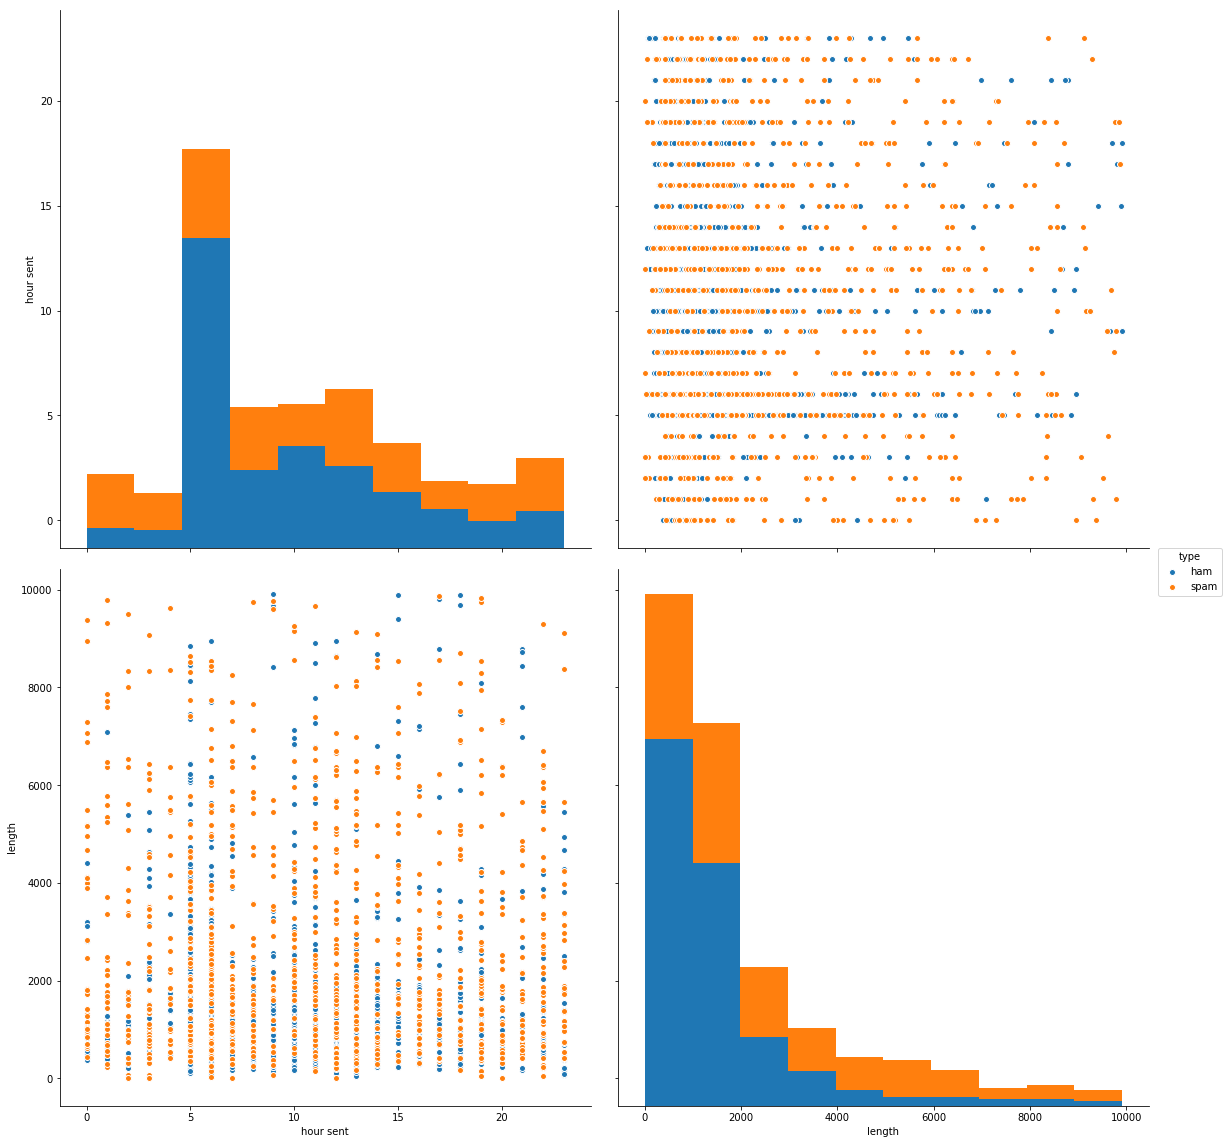

In [23]:
sns.pairplot(df, hue='type', size=8, aspect=1)

The boxplot below shows that most ham emails are in that ten hour window, spiking in the early hours of that window, while
spam emails have a much wider spread, but also spiking during those ten hours.

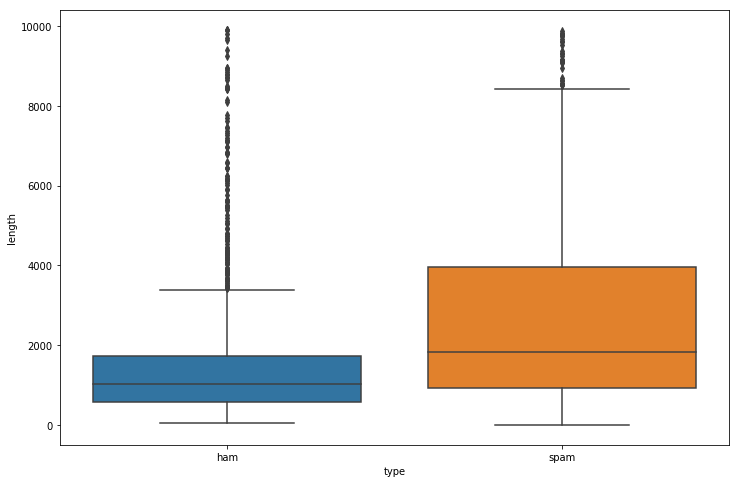

In [24]:
plt.figure(figsize=(12,8))
sns.boxplot(x='type',y='length',data=df)

### Preprocessing






For a simple approach, we will have just one input feature and one target feature.

In [25]:
simple_df = df[['message', 'type']]

The following function is used to clean our data before the individual words are vectorized. HTML tags, punctuation and stopwords are removed

In [26]:
def clean_words(mess):
    #for use within vectorizer
    no_tags = re.compile('<.*?>')
    no_tags = re.sub(no_tags, '', mess)
    #removes all html tags using the re library
    no_punc = [char for char in no_tags if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    #removes all punctuation using the string library
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]#removes stop words

Create a pipeline. For our first run we will use CountVectorizer to vectorize the email body.

In [27]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(analyzer=clean_words))])

# Fitting, Training and Predictions

Fit the pipeline to our training data.

In [28]:
pipeline.fit(simple_df['message'])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer=<function clean_words at 0x7f90a6ae0e18>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None))])

In [29]:
X = pipeline.transform(simple_df['message'])
y = simple_df['type']

Train test split. One third of the examples are reserved for testing our model.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

For our first run we will use Logistic Regression as our classifiction model. The model is fir to our training data.

In [31]:
logr = LogisticRegression()

In [32]:
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Our newly trained model can now be used to make predictions on our test data.

In [33]:
predictions = logr.predict(X_test)

We can now compare our models predicted labels with the actual labels. The confusion matrix shows how many false positives and false negatives
were made when determining which emails were spam or ham, and the classification report gives a more detailed account of the performance.

In [34]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))
print('\n')
print('Classification Report:')
print(classification_report(y_test, predictions))

Confusion Matrix:
[[457  16]
 [  9 320]]


Classification Report:
             precision    recall  f1-score   support

        ham       0.98      0.97      0.97       473
       spam       0.95      0.97      0.96       329

avg / total       0.97      0.97      0.97       802



# Comparisons

Comparing the results of different vectorizers and classifier models.

In [35]:
countv = CountVectorizer(analyzer=clean_words)
tfidf = TfidfVectorizer(analyzer=clean_words)
logr = LogisticRegression()
mnb = MultinomialNB()
dtree = DecisionTreeClassifier()
rforest = RandomForestClassifier()

In [36]:
vectorizers = [countv, tfidf]
v_names = ['Count Vectorizer', 'TF-IDF Vectorizer']
classifiers = [logr, mnb, dtree, rforest]
c_names = ['Logistic Regression', 'Multinomial Naive Bayes', 'Decision Tree', 'Random Forest']

In [37]:
for i in range(len(vectorizers)):
    for j in range(len(classifiers)):
        pipeline = Pipeline([
        ('vectorizer', vectorizers[i])])
        pipeline.fit(simple_df['message'])
        X = pipeline.transform(simple_df['message'])
        y = simple_df['type']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        classifier = classifiers[j]
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        print('#--------------------------------------------------#')
        print('Vectorizer: ', v_names[i])
        print('Classifier: ', c_names[j])
        print('\n')
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, predictions))
        print('\n')
        print('Classification Report:')
        print(classification_report(y_test, predictions))
        print('#--------------------------------------------------#')

#--------------------------------------------------#
Vectorizer:  Count Vectorizer
Classifier:  Logistic Regression


Confusion Matrix:
[[457  16]
 [  9 320]]


Classification Report:
             precision    recall  f1-score   support

        ham       0.98      0.97      0.97       473
       spam       0.95      0.97      0.96       329

avg / total       0.97      0.97      0.97       802

#--------------------------------------------------#
#--------------------------------------------------#
Vectorizer:  Count Vectorizer
Classifier:  Multinomial Naive Bayes


Confusion Matrix:
[[466   7]
 [ 15 314]]


Classification Report:
             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       473
       spam       0.98      0.95      0.97       329

avg / total       0.97      0.97      0.97       802

#--------------------------------------------------#
#--------------------------------------------------#
Vectorizer:  Count Vectorizer
Classifie

# Results

From the classification reports and confusion matrices we can see that the count vectorizer performed better on the dataset alongside either the
Logistic Regression or Multinomial Naive Bayes classifiers. The Logistic Regression classifier seems to have performed better at correctly labeling
spam while the Multinomial Naive Bayes classifier performed better at correctly labeling ham.

# Experimenting with Extra Features

As we saw in the visualisations, there appeared to be certain amount of correlation between both message length and hour sent, and whether it was ham or spam. It would be interesting to attempt to include these features in the classification.

In [50]:
def clean_words(mess):
    no_tags = re.compile(b'<.*?>')
    no_tags = str(re.sub(no_tags, '', mess))
    no_punc = [char for char in no_tags if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

numeric_features = ['length', 'hour sent']
text_features = ['message']

numeric_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_features, dtype='float64')),
        ('scaler', StandardScaler())
    ])

text_pipeline = Pipeline([
        ('selector', DataFrameSelector(text_features)), 
        ('vectorizer', CountVectorizer(analyzer=clean_words))
    ])

pipeline = Pipeline([('union', FeatureUnion([('numeric_pipeline', numeric_pipeline), 
                                             ('text_pipeline', text_pipeline)]))])

In [53]:
pipeline.fit(df.drop('type', axis=1))

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['length', 'hour sent'], dtype='float64')), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('text_pipeline', Pipeline(memory=None,
     steps=[('selector'...strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None))]))],
       transformer_weights=None))])

In [54]:
X = pipeline.transform(df.drop('type', axis=1))
y = df['type']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [56]:
logr = LogisticRegression()

In [57]:
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
predictions = logr.predict(X_test)

In [59]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[420  65]
 [195 122]]


             precision    recall  f1-score   support

        ham       0.68      0.87      0.76       485
       spam       0.65      0.38      0.48       317

avg / total       0.67      0.68      0.65       802



We can see from this that the numeric features do not mix so readily with the language features and our purely NLP solution proved to be far more accurate.